In [100]:
import os
import time

import numpy as np
import pylab as plt
from scipy import stats

import pymc3 as pm
import theano
import theano.tensor as tt

## Generate synthetic data

In [113]:
# Some poisson spiking
length = 1000
bin_width = 10
states = 3
nrns = 10
tastes = 4
trials = 20
idx = np.arange(length)

true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:,:-1]

true_lambda = np.random.random((tastes,nrns,states))

true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r   

# Spike array : tastes x trials x neurons x timebins
spike_array = np.sum(data_array.reshape((*data_array.shape[:3],-1,bin_width)),axis=-1)
spike_array_long = np.concatenate(spike_array, axis=0) 

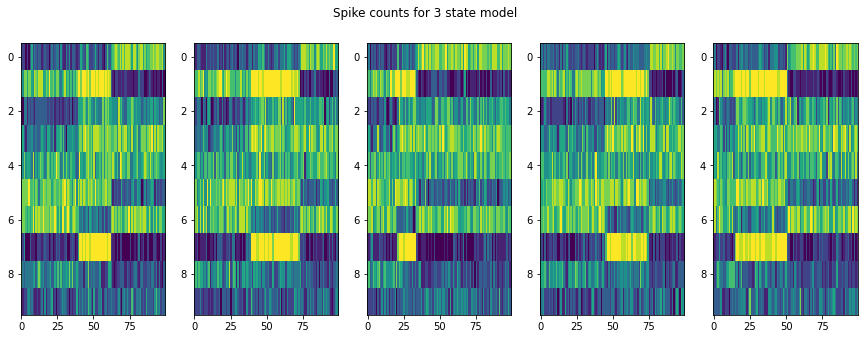

In [114]:
## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(spike_array[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

## Define model

In [115]:
def all_taste_poisson(
        spike_array,
        states):

    """
    spike_array :: Shape : tastes, trials, neurons, time_bins
    states :: number of states to include in the model 
    
    ** Based off of mode from (Ref 1)
    """

    # Unroll arrays along taste axis
    spike_array_long = np.concatenate(spike_array, axis=0) 

    # Define dimension variables for convenience
    tastes = spike_array.shape[0]
    length = spike_array.shape[-1]
    nrns = spike_array.shape[2]
    trials = spike_array.shape[1]

    # Find mean firing for each neuron for initial values
    split_list = np.array_split(spike_array,states,axis=-1)
    min_val = min([x.shape[-1] for x in split_list])
    split_array = np.array([x[...,:min_val] for x in split_list])
    mean_vals = np.mean(split_array,axis=(2,-1)).swapaxes(0,1)
    mean_vals += 0.01 # To avoid zero starting prob
    mean_nrn_vals = np.mean(mean_vals,axis=(0,1))

    # Find evenly spaces switchpoints for initial values
    idx = np.arange(spike_array.shape[-1]) # Index
    array_idx = np.broadcast_to(idx, spike_array_long.shape)
    even_switches = np.linspace(0,idx.max(),states+1)
    even_switches_normal = even_switches/np.max(even_switches)

    # Define taste identifier for each trial
    taste_label = np.repeat(np.arange(spike_array.shape[0]), spike_array.shape[1])
    trial_num = array_idx.shape[0]

    # Begin constructing model
    with pm.Model() as model:

        #############################################################
        ## EMISSION VARIABLES
        #############################################################
        
        # Hierarchical firing rates
        # Refer to model diagram
        # **Note: Since support of Exponential distribution is [0,inf), it satisfies
        # ** requirement to be the lambda parameter for another Exponential distribution
        
        # EQ 1
        # =====
        # Mean firing rate of neuron AT ALL TIMES
        lambda_nrn = pm.Exponential('lambda_nrn',
                                    1/mean_nrn_vals,
                                    shape=(mean_vals.shape[-1]))
        # EQ 2
        # =====
        # Priors for each state, derived from each neuron
        # Mean firing rate of neuron IN EACH STATE (averaged across tastes)
        lambda_state = pm.Exponential('lambda_state',
                                      lambda_nrn,
                                      shape=(mean_vals.shape[1:]))
        # EQ 3
        # =====
        # Mean firing rate of neuron PER STATE PER TASTE
        lambda_latent = pm.Exponential('lambda',
                                       lambda_state[np.newaxis, :, :],
                                       testval=mean_vals,
                                       shape=(mean_vals.shape))

        #############################################################
        ## Changepoint Position Variables 
        #############################################################
        
        # EQ 4
        # =====
        # INDEPENDENT TAU FOR EVERY CHANGEPOINT
        # But shared across trials
        a = pm.HalfNormal('a_tau', 3., shape=states - 1)
        b = pm.HalfNormal('b_tau', 3., shape=states - 1)
        
        # EQ 5
        # =====
        # Stack produces states x trials --> That gets transposed
        # to trials x states and gets sorted along states (axis=-1)
        tau_latent = pm.Beta('tau_latent', a, b,
                             shape=(trial_num, states-1),
                             testval=tt.tile(even_switches_normal[1:(states)],
                                             (array_idx.shape[0], 1))).sort(axis=-1)
        
        # EQ 6
        # =====
        # Expand tau_latent for [0,1] --> [0, max_time_bin]
        tau = pm.Deterministic('tau',
                               idx.min() + (idx.max() - idx.min()) * tau_latent)

        #############################################################
        ## Likelihood 
        #############################################################
        
        # EQ 8
        # =====
        # Emissions (lambda) and changepoint positions (tau) are used to generate
        # timeseries of firing rates over the (trials x neurons x timebins) array
        # Sigmoids are used to "select" a particular state for contiguous time segments
        # Refer to (https://www.desmos.com/calculator/yisbydv2cq) for a visual example
        
        weight_stack = tt.nnet.sigmoid(
            idx[np.newaxis, :]-tau[:, :, np.newaxis])
        weight_stack = tt.concatenate(
            [np.ones((tastes*trials, 1, length)), weight_stack], axis=1)
        inverse_stack = 1 - weight_stack[:, 1:]
        inverse_stack = tt.concatenate([inverse_stack, np.ones(
            (tastes*trials, 1, length))], axis=1)
        weight_stack = weight_stack*inverse_stack
        weight_stack = tt.tile(weight_stack[:, :, None, :], (1, 1, nrns, 1))

        lambda_latent = lambda_latent.dimshuffle(2, 0, 1)
        lambda_latent = tt.repeat(lambda_latent, trials, axis=1)
        lambda_latent = tt.tile(
            lambda_latent[..., None], (1, 1, 1, length))
        lambda_latent = lambda_latent.dimshuffle(1, 2, 0, 3)
        lambda_ = tt.sum(lambda_latent * weight_stack, axis=1)

        # EQ 7
        # =====
        # Output from above calculation is used as emission rate for every timepoint
        # Likelihood is calculated as independent Poisson
        observation = pm.Poisson("obs", lambda_, observed=spike_array_long)

    return model

In [116]:
model = all_taste_poisson(
        spike_array = spike_array,
        states = states)

In [117]:
# pm.model_to_graphviz(model)

In [118]:
# gv = pm.model_to_graphviz(model)
# gv.render(filename='./figs/all_taste_poisson_model',format='png');

## Model Structure

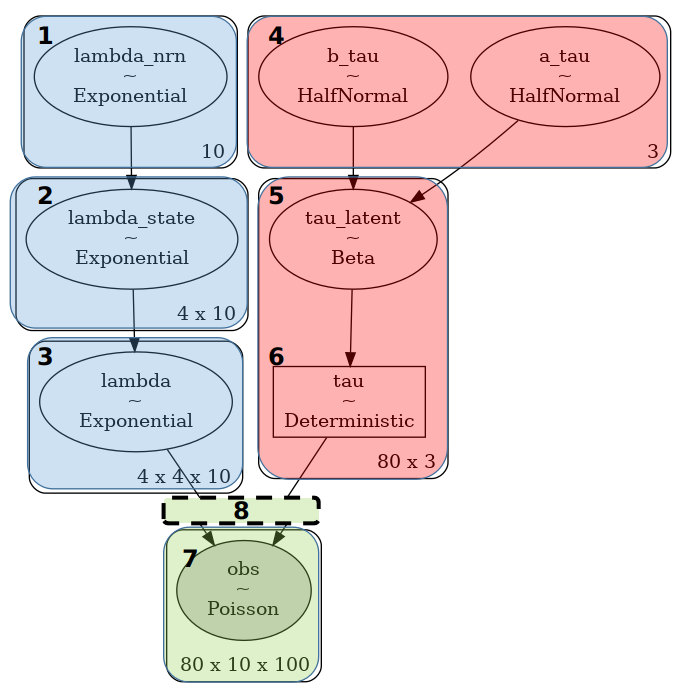

- Blue -->  Emission Variables
- Red  -->  Changepoint Position Varialbes
- Green --> Likelihood

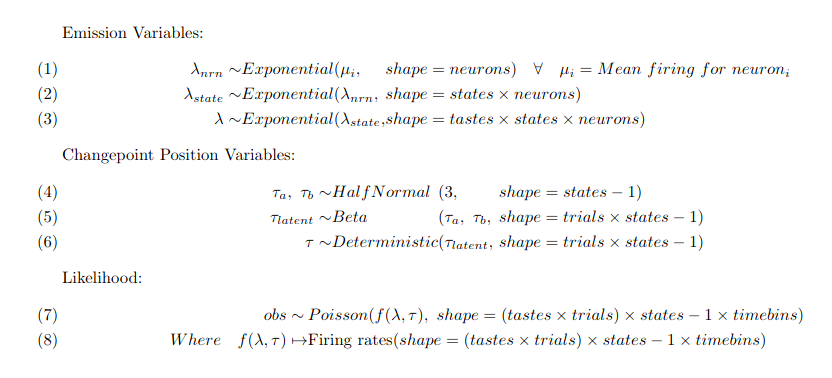

## Inference

In [119]:
fit = 40000 # Number of steps for model fitting
samples = 20000 # Number of samples to draw from fitted model
with model:
    # Use ADVI (Refs 2,3)
    approx = pm.fit(n=fit, method=pm.ADVI('full-rank'))
    trace = approx.sample(draws=samples)

Finished [100%]: Average Loss = 1.4927e+05


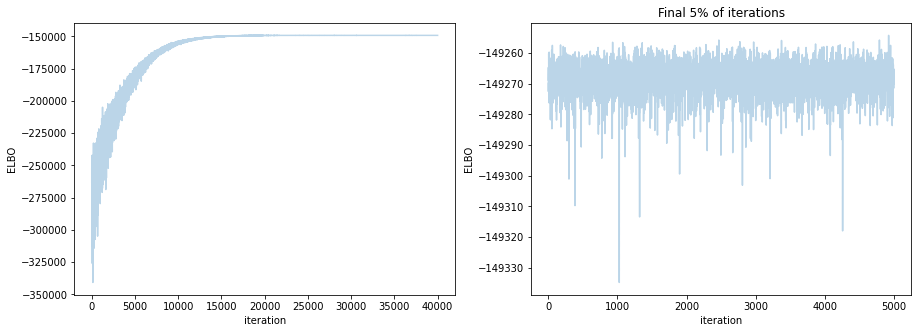

In [120]:
# Visually inspect ELBO history for convergence
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

## Visualize outputs

In [121]:
# Extract inferrred changepoints
tau = trace['tau']
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]

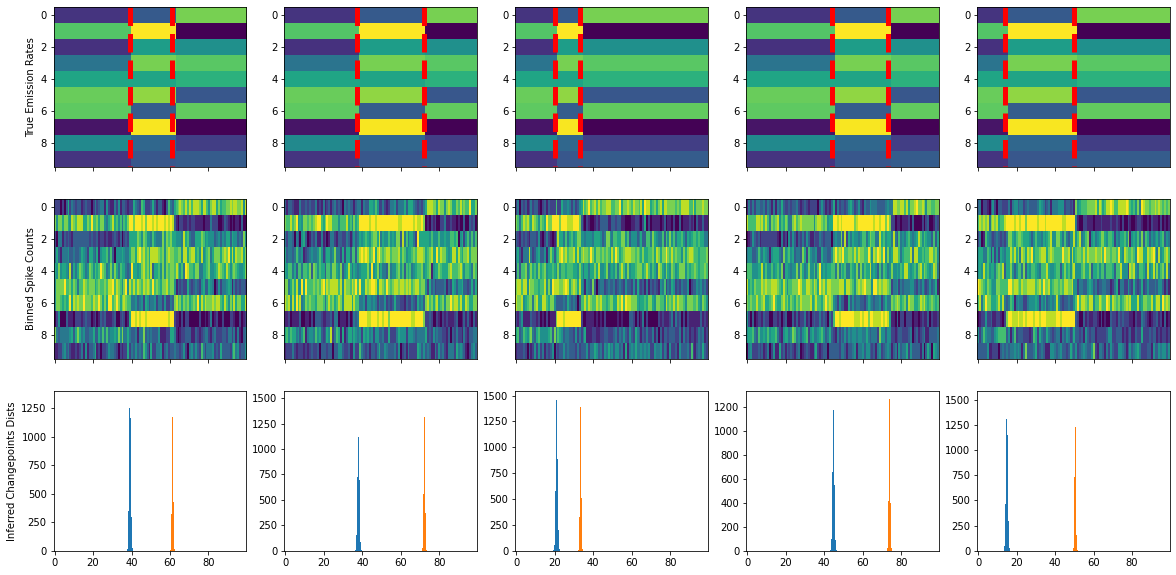

In [124]:
trial_inds = np.arange(5)
fig,ax = plt.subplots(3,trial_count,sharex=True,figsize=(20,10))
for trial_num,this_trial_ind in enumerate(trial_inds):
    ax[0,trial_num].imshow(np.concatenate(true_r,axis=0)[this_trial_ind][...,::bin_width],aspect='auto', interpolation='nearest')
    ax[1,trial_num].imshow(spike_array_long[this_trial_ind],aspect='auto', interpolation='nearest')
    
    for tau_num, this_tau in enumerate(tau[:,this_trial_ind].T):
        ax[2,trial_num].hist(this_tau,bins=50)
        ax[0,trial_num].vlines(mode_tau[this_trial_ind,tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')
        
ax[0,0].set_ylabel('True Emission Rates');
ax[1,0].set_ylabel('Binned Spike Counts');
ax[2,0].set_ylabel('Inferred Changepoints Dists');

## References

1. Probabilistic Programming & Bayesian Methods for Hackers : http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/
2. Pymc3 Variational Inference primer : https://docs.pymc.io/en/v3/pymc-examples/examples/variational_inference/variational_api_quickstart.html
3. Automatic Differentiation Variational Inference (https://doi.org/10.48550/arXiv.1603.00788)